In [1]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import cv2
import numpy as np
from sklearn.cluster import DBSCAN

In [2]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

import numpy as np
import os
import re

from PIL import Image as im
import numpy as np
from path import Path
import matplotlib.pyplot as plt
import cv2
from typing import List
import argparse

In [3]:
@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox

In [4]:
def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    """Scale space technique for word segmentation proposed by R. Manmatha.

    For details see paper http://ciir.cs.umass.edu/pubfiles/mm-27.pdf.

    Args:
        img: A grayscale uint8 image.
        kernel_size: The size of the filter kernel, must be an odd integer.
        sigma: Standard deviation of Gaussian function used for filter kernel.
        theta: Approximated width/height ratio of words, filter function is distorted by this factor.
        min_area: Ignore word candidates smaller than specified area.

    Returns:
        List of DetectorRes instances, each containing the bounding box and the word image.
    """
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    a=0
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))
    return res

In [5]:
def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    """Compute anisotropic filter kernel."""

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel

In [6]:
def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    """Convert image to grayscale image (if needed) and resize to given height."""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)

In [7]:
def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)

    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


In [8]:
def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    """Cluster detections into lines, then sort the lines according to x-coordinates of word centers.

    Args:
        detections: List of detections.
        max_dist: Maximum Jaccard distance (0..1) between two y-projected words to be considered as neighbors.
        min_words_per_line: If a line contains less words than specified, it is ignored.

    Returns:
        List of lines, each line itself a list of detections.
    """
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res

In [9]:
def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]

In [10]:
def get_img_files(data_dir: Path) -> List[Path]:
    """Return all image files contained in a folder."""
    res = []
    for ext in ['*.png', '*.jpg', '*.bmp']:
        res += Path(data_dir).files(ext)
    return res

In [11]:
def save_image_names_to_text_files(source_path,img_height,kernel_size,sigma,theta,min_area):

    for fn_img in get_img_files(source_path):
        print(f'Processing file {fn_img}')

        # load image and process it
        img = prepare_img(cv2.imread(fn_img),img_height)
        detections = detect(img,
                            kernel_size=kernel_size,
                            sigma=sigma,
                            theta=theta,
                            min_area=min_area)

        # sort detections: cluster into lines, then sort each line
        lines = sort_multiline(detections)

        # plot results
        plt.imshow(img, cmap='gray')
        num_colors = 7
        colors = plt.cm.get_cmap('rainbow', num_colors)
        for line_idx, line in enumerate(lines):
            for word_idx, det in enumerate(line):
                xs = [det.bbox.x, det.bbox.x, det.bbox.x +
                      det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
                ys = [det.bbox.y, det.bbox.y + det.bbox.h,
                      det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
                plt.plot(xs, ys, c=colors(line_idx % num_colors))
                plt.text(det.bbox.x, det.bbox.y, f'{line_idx}/{word_idx}')
                print(det.bbox.x, det.bbox.y, det.bbox.w, det.bbox.h)
                crop_img = img[det.bbox.y:det.bbox.y +
                               det.bbox.h, det.bbox.x:det.bbox.x+det.bbox.w]
                
                path = './test_images'
                # Check whether the specified
                # path exists or not
                isExist = os.path.exists(path)
                if isExist == False:
                    os.mkdir(path)
                    print("Directory Created")

                cv2.imwrite(f"{path}/line" + str(line_idx) + "word" +
                            str(word_idx) + ".jpg", crop_img)
                full_img_path = "line" + \
                    str(line_idx) + "word" + str(word_idx)+".jpg"
                list_img_names_serial.append(full_img_path)
                print(list_img_names_serial)
                list_img_names_serial_set = set(list_img_names_serial)

                textfile = open("./img_names_sequence.txt", "w")
                for element in list_img_names_serial:
                    textfile.write(element + "\n")
                textfile.close()

        plt.show()


In [12]:
source_path = Path(".")
kernel_size = 25
sigma =11
theta = 7

min_area = 100
img_height = 2000
list_img_names_serial = []

Processing file .\r06-137.png
33 28 151 77
Directory Created
['line0word0.jpg']
250 77 19 16
['line0word0.jpg', 'line0word1.jpg']
382 90 14 12
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg']
237 30 468 84
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg']
772 30 311 79
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg']
1135 44 90 65
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line0word5.jpg']
1234 78 38 40
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line0word5.jpg', 'line0word6.jpg']
1347 90 17 12
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line0word5.jpg', 'line0word6.jpg', 'line0word7.jpg']
1332 43 479 75
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line0word5.jpg', 'line0word6.jpg', 'line0word7.jpg', 'line0word8.jpg']
48 212 75

C:\Users\nimes\AppData\Local\Temp\ipykernel_8988\1822276140.py:19: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  x_term = (x ** 2 - sigma_x ** 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
C:\Users\nimes\AppData\Local\Temp\ipykernel_8988\1822276140.py:20: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  y_term = (y ** 2 - sigma_y ** 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)
C:\Users\nimes\AppData\Local\Temp\ipykernel_8988\1845084007.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', num_colors)


['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line0word5.jpg', 'line0word6.jpg', 'line0word7.jpg', 'line0word8.jpg', 'line1word0.jpg', 'line1word1.jpg', 'line1word2.jpg', 'line1word3.jpg', 'line1word4.jpg', 'line1word5.jpg', 'line1word6.jpg', 'line1word7.jpg', 'line1word8.jpg', 'line1word9.jpg', 'line1word10.jpg', 'line2word0.jpg', 'line2word1.jpg', 'line2word2.jpg', 'line2word3.jpg', 'line2word4.jpg', 'line2word5.jpg', 'line2word6.jpg', 'line2word7.jpg', 'line2word8.jpg', 'line2word9.jpg', 'line3word0.jpg', 'line3word1.jpg', 'line3word2.jpg', 'line3word3.jpg', 'line3word4.jpg', 'line3word5.jpg']
1839 650 73 34
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line0word5.jpg', 'line0word6.jpg', 'line0word7.jpg', 'line0word8.jpg', 'line1word0.jpg', 'line1word1.jpg', 'line1word2.jpg', 'line1word3.jpg', 'line1word4.jpg', 'line1word5.jpg', 'line1word6.jpg', 'line1word7.jpg', 'line1word8.jpg', 'line1word

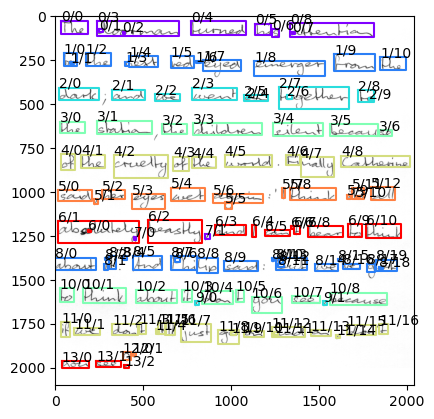

In [13]:
save_image_names_to_text_files(source_path=source_path,kernel_size=kernel_size,sigma=sigma,theta=theta,min_area=min_area,img_height=img_height)

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
base_path = "./"
## Testing data input pipeline 
base_image_path = os.path.join(base_path, "test_images")
print(base_image_path)

./test_images


In [16]:
t_images = []
from os import listdir
from os.path import isfile, join

# onlyfiles = [f for f in listdir(base_image_path) if isfile(join(base_image_path, f))]
for f in listdir(base_image_path):
  t_images_path = os.path.join(base_image_path, f)
  t_images.append(t_images_path)

print(t_images)

['./test_images\\line0word0.jpg', './test_images\\line0word1.jpg', './test_images\\line0word2.jpg', './test_images\\line0word3.jpg', './test_images\\line0word4.jpg', './test_images\\line0word5.jpg', './test_images\\line0word6.jpg', './test_images\\line0word7.jpg', './test_images\\line0word8.jpg', './test_images\\line10word0.jpg', './test_images\\line10word1.jpg', './test_images\\line10word2.jpg', './test_images\\line10word3.jpg', './test_images\\line10word4.jpg', './test_images\\line10word5.jpg', './test_images\\line10word6.jpg', './test_images\\line10word7.jpg', './test_images\\line10word8.jpg', './test_images\\line11word0.jpg', './test_images\\line11word1.jpg', './test_images\\line11word10.jpg', './test_images\\line11word11.jpg', './test_images\\line11word12.jpg', './test_images\\line11word13.jpg', './test_images\\line11word14.jpg', './test_images\\line11word15.jpg', './test_images\\line11word16.jpg', './test_images\\line11word2.jpg', './test_images\\line11word3.jpg', './test_images\

In [17]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [18]:
t_images.sort(key=natural_keys)
print(t_images)

['./test_images\\line0word0.jpg', './test_images\\line0word1.jpg', './test_images\\line0word2.jpg', './test_images\\line0word3.jpg', './test_images\\line0word4.jpg', './test_images\\line0word5.jpg', './test_images\\line0word6.jpg', './test_images\\line0word7.jpg', './test_images\\line0word8.jpg', './test_images\\line1word0.jpg', './test_images\\line1word1.jpg', './test_images\\line1word2.jpg', './test_images\\line1word3.jpg', './test_images\\line1word4.jpg', './test_images\\line1word5.jpg', './test_images\\line1word6.jpg', './test_images\\line1word7.jpg', './test_images\\line1word8.jpg', './test_images\\line1word9.jpg', './test_images\\line1word10.jpg', './test_images\\line2word0.jpg', './test_images\\line2word1.jpg', './test_images\\line2word2.jpg', './test_images\\line2word3.jpg', './test_images\\line2word4.jpg', './test_images\\line2word5.jpg', './test_images\\line2word6.jpg', './test_images\\line2word7.jpg', './test_images\\line2word8.jpg', './test_images\\line2word9.jpg', './test_

In [19]:
with open('characters_list.pkl', 'rb') as file:
    ff_loaded = pickle.load(file)

# Verify if the loaded list is the same as the original
print(ff_loaded)

['w', 'K', '6', 's', '?', 'W', 'Y', 'Q', 'i', "'", '(', 'u', 'M', 'T', '1', 'I', 'v', 'A', 'k', '.', '4', 'N', 'Z', 'U', 'E', 't', 'C', '2', '/', 'p', 'G', 'H', 'm', ';', 'L', 'P', '9', ':', 'D', 'j', 'J', '#', 'h', 'x', 'R', '+', '0', '3', 'F', 'B', '"', '!', 'b', 'e', ',', 'o', '8', 'S', 'V', 'f', 'q', '7', 'y', 'X', 'g', 'd', ')', 'O', 'l', '5', 'n', '-', 'c', 'r', 'a', '&', 'z', '*']


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

#mapping characters to integers
char_to_num = StringLookup(vocabulary = ff_loaded,mask_token = None)

#mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary = char_to_num.get_vocabulary(),mask_token=None, invert = True
)

In [21]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

max_len = 21

def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  # Check tha amount of padding needed to be done.
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  # only necessary if you want to do same amount of padding on both sides.
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image, paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0, 0],
      ],
  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image


# Testing inference images
def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def process_images_2(image_path):
  image = preprocess_image(image_path)
  # label = vectorize_label(label)
  return {"image": image}
  
def prepare_test_images(image_paths):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
    process_images_2, num_parallel_calls=AUTOTUNE
  )

  # return dataset
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

inf_images = prepare_test_images(t_images)

In [22]:
class CTCLayer(keras.layers.Layer):

  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions.
    return y_pred

In [23]:
custom_objects = {"CTCLayer": CTCLayer}

reconstructed_model = keras.models.load_model("saved models/handwriting_recognizer_50.h5", custom_objects=custom_objects)
prediction_model = keras.models.Model(
  reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output
)

In [24]:
pred_test_text = []

In [25]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text

(64, 128, 32, 1)
2/2 [==============================] - 1s 17ms/step



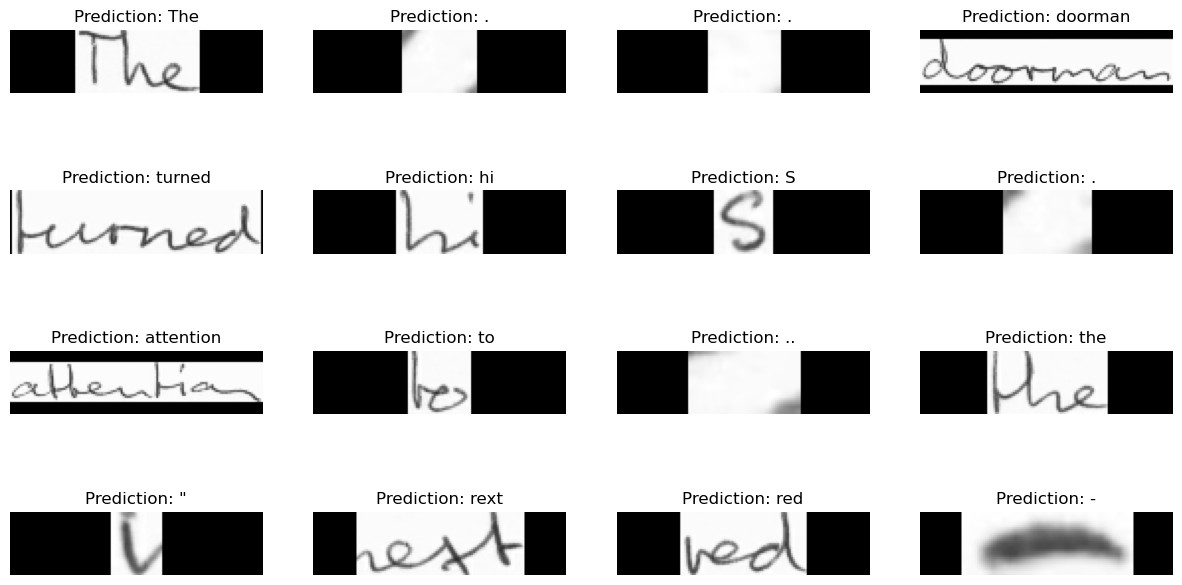

(61, 128, 32, 1)
2/2 [==============================] - 1s 18ms/step


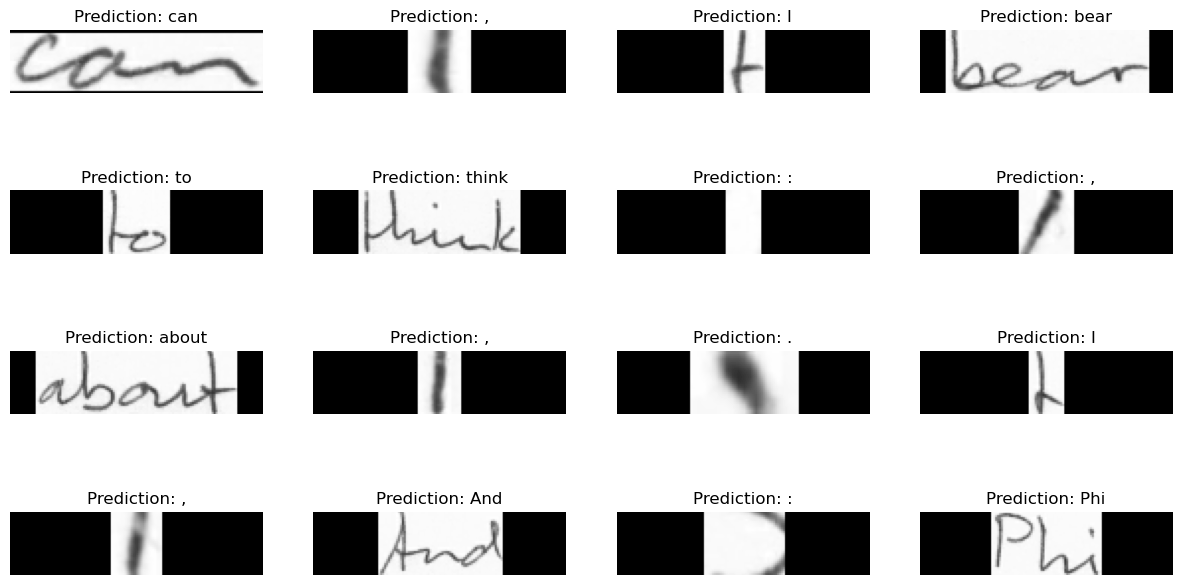

['The', '.', '.', 'doorman', 'turned', 'hi', 'S', '.', 'attention', 'to', '..', 'the', '"', 'rext', 'red', '-', 'ened', 'emerger', 'from', 'the', 'dark', 'and', 'be', 'went', '.', 'onn', '.', 'together', 'to', '.', 'the', 'station', 'the', 'children', 'silent', 'becau', 'se', 'of', 'the', 'cruelty', 'of', 'the', 'world', 'Fi', 'maly', 'Catherine', 'said', ',', 'her', 'eyes', 'wet', 'a', 'agam', 'I', 'think', ',', '..', 'to', 'all', '.', 'abolutely', 'beastly', 'and', 'I', 'can', ',', 'I', 'bear', 'to', 'think', ':', ',', 'about', ',', '.', 'I', ',', 'And', ':', 'Phi', 'Lip', 'said', ',', '..', '..', 'But', 'we', ',', 've', 'a', '.', 'of', ',', ',', 'to', 'think', 'about', 'it', 'dow', 't', 'you', 'see', 'because', 'if', 'we', 'doi', 't', ',', 'it', "'ll", 'just', 'go', '..', 'on', '.', 'and', 'an', ',', 'don', 't', 'a', ',', 'non', 'see', '.']
The . . doorman turned hi S . attention to .. the " rext red - ened emerger from the dark and be went . onn . together to . the station the chil

In [26]:
for batch in inf_images.take(3):
    batch_images = batch["image"]
    # batch_images= tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)
    # print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()


flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

sentence = ' '.join(flat_list)
print(sentence)